# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

In [1]:
# Write your code here
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from itertools import product

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.metrics import MeanAbsolutePercentageError

from optimize_SARIMA import optimize_SARIMA
from data_window_class import WindowGenerator
from compile_and_fit import compile_and_fit

In [59]:
tf.random.set_seed(150)
np.random.seed(150)

<h1>Data Preprocessing</h1>

In [2]:
lf = pl.scan_csv('sudeste.csv', try_parse_dates=True)
lf.head().collect()

wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
i64,str,f64,f64,f64,str,str,str,datetime[μs],date,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 00:00:00,2007-11-06,2007,11,6,0,null,982.5,982.5,981.3,null,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 01:00:00,2007-11-06,2007,11,6,1,null,983.2,983.2,982.5,null,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 02:00:00,2007-11-06,2007,11,6,2,null,983.5,983.5,983.2,null,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 03:00:00,2007-11-06,2007,11,6,3,null,983.7,983.7,983.4,null,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 04:00:00,2007-11-06,2007,11,6,4,null,983.7,983.8,983.6,null,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [3]:
lf_wsid_count_per_city = lf.select(['wsid', 'city']).group_by('city', maintain_order=True).n_unique().sort('wsid', descending=True)
lf_wsid_count_per_city.collect()

city,wsid
str,u32
"""Rio de Janeiro""",4
"""Belo Horizonte""",2
"""Campos dos Goytacazes""",2
"""São Gonçalo""",1
"""Vitória""",1
…,…
"""Barra do Turvo""",1
"""Pradópolis""",1
"""Barretos""",1


In [4]:
dropped_columns = ['wsid', 'wsnm', 'inme', 'city', 'prov', 'elvt', 'lat', 'lon']
sao_paulo_lf = lf.filter(pl.col('city') == 'São Paulo').drop(dropped_columns)
sao_paulo_df = sao_paulo_lf.collect().to_pandas()
sao_paulo_df.set_index('mdct', inplace=True)

In [5]:
sao_paulo_2015_df = sao_paulo_df[sao_paulo_df.index.year == 2015]
sao_paulo_dec_2015_df = sao_paulo_2015_df[sao_paulo_2015_df.index.month == 12]

In [6]:
timestamp_s = sao_paulo_dec_2015_df.index.map(datetime.datetime.timestamp)
day = 24 * 60 * 60

sao_paulo_dec_2015_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
sao_paulo_dec_2015_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

C:\Users\Shaun\AppData\Local\Temp\ipykernel_117784\2771466758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sao_paulo_dec_2015_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
C:\Users\Shaun\AppData\Local\Temp\ipykernel_117784\2771466758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sao_paulo_dec_2015_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values


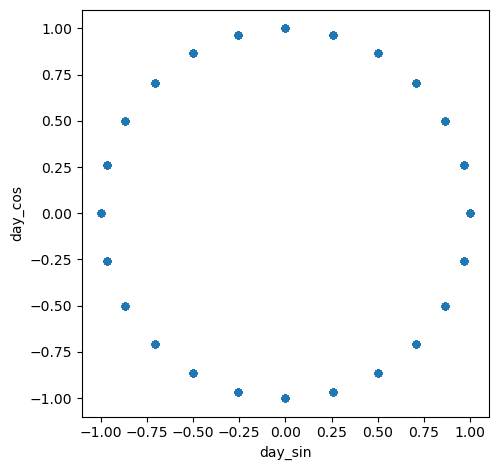

In [7]:
sao_paulo_dec_2015_df.plot.scatter('day_sin','day_cos').set_aspect('equal')
plt.tight_layout()


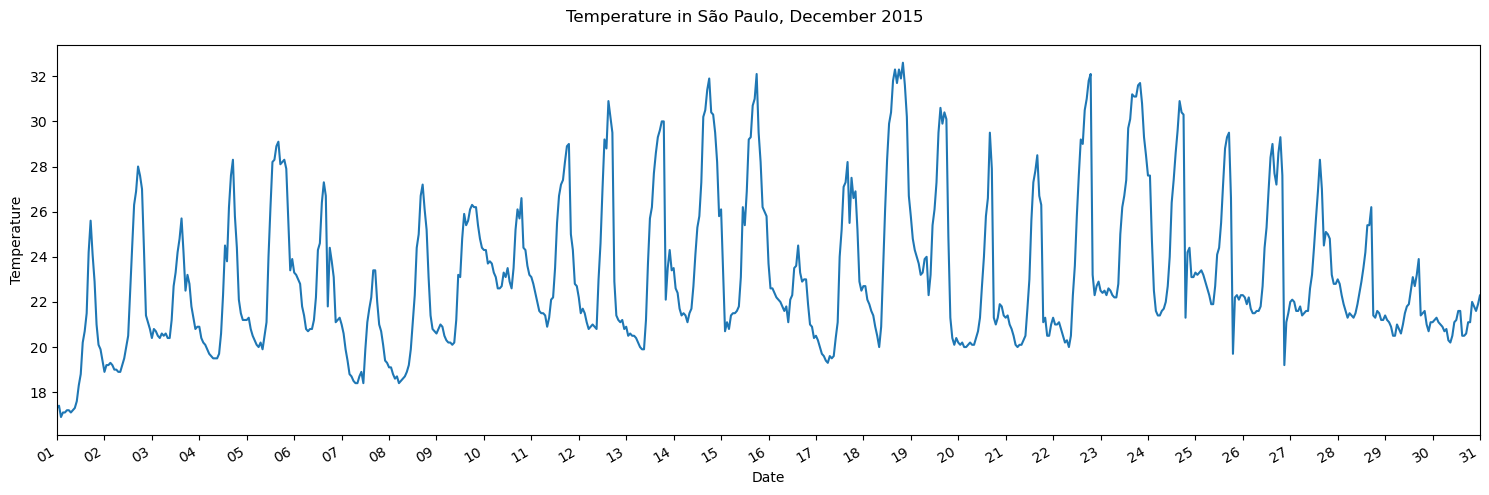

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sao_paulo_dec_2015_df['temp'])
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2015-12-31'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
fig.suptitle('Temperature in São Paulo, December 2015')

fig.autofmt_xdate()
plt.tight_layout()

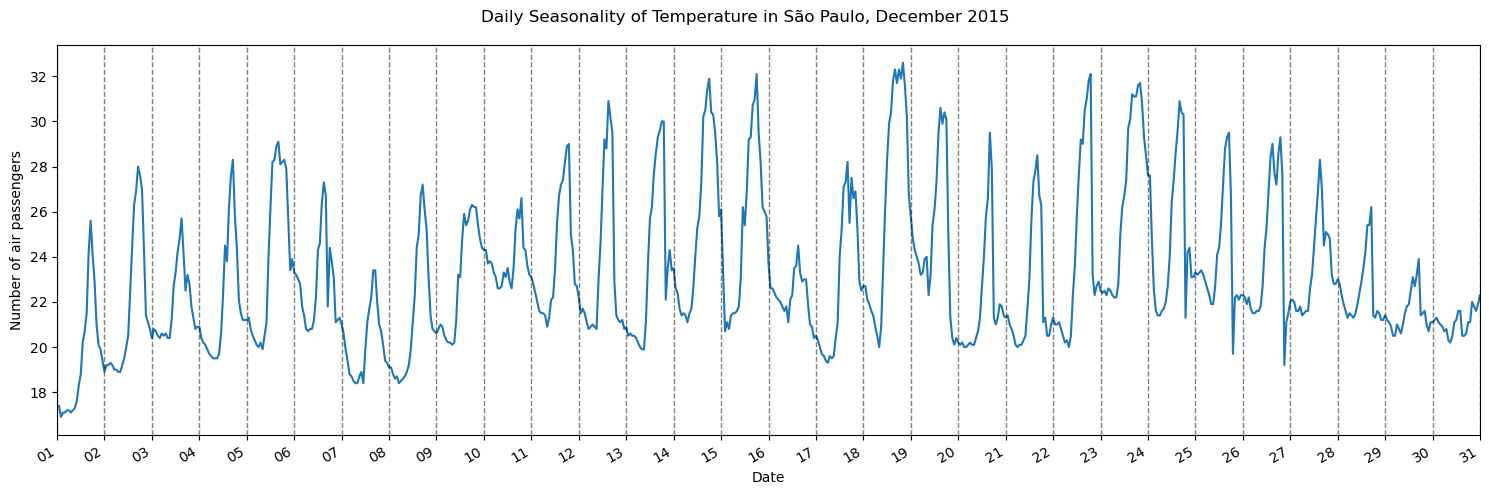

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sao_paulo_dec_2015_df['temp'])
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2015-12-31'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
for day in pd.date_range(start='2015-12-01', end='2015-12-31', freq='D'):
    ax.axvline(x=day, linestyle='--', color='black', linewidth=1, alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
fig.suptitle('Daily Seasonality of Temperature in São Paulo, December 2015')

fig.autofmt_xdate()
plt.tight_layout()


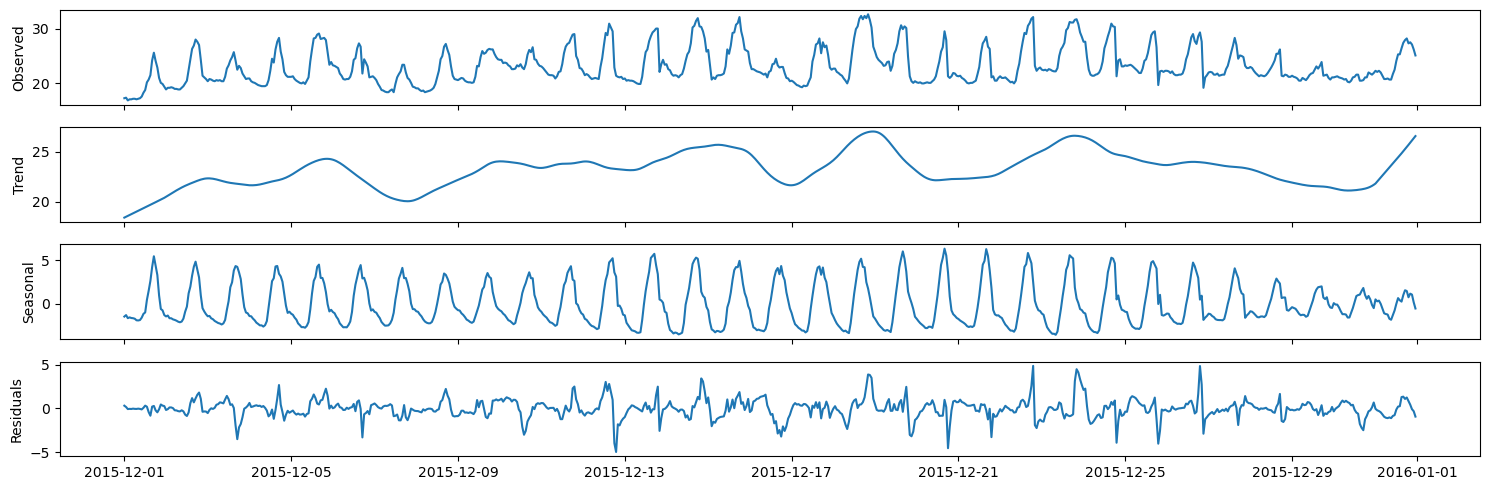

In [10]:
decomposition = STL(sao_paulo_dec_2015_df['temp'], period=24).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,5))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.tight_layout()

In [11]:
ad_fuller_result = adfuller(sao_paulo_dec_2015_df['temp'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.024311826143162
p-value: 0.032685517344827296


In [12]:
full_train, test = train_test_split(sao_paulo_dec_2015_df[['temp', 'day_sin', 'day_cos']], test_size=0.2, shuffle=False)
train, val = train_test_split(full_train, test_size=len(test), shuffle=False)

scaler = MinMaxScaler().set_output(transform='pandas')
scaler.fit(train)
train_scaled = scaler.transform(train[train.columns])
val_scaled = scaler.transform(val[val.columns])
test_scaled = scaler.transform(test[test.columns])

<h1>SARIMA Model</h1>

In [43]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 0
D = 0
s = 24

SARIMA_result_df = optimize_SARIMA(full_train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i

,"(p,q,P,Q)",AIC
0,"(0, 2, 2, 1)",12.000000
1,"(2, 2, 1, 3)",1817.326790
2,"(3, 2, 1, 3)",1818.417860
3,"(2, 1, 3, 3)",1820.220609
4,"(2, 1, 3, 1)",1820.738667
...,...,...
244,"(0, 1, 0, 1)",4037.639873
245,"(0, 0, 0, 2)",4235.915740
246,"(0, 1, 0, 0)",4668.417399
247,"(0, 0, 0, 1)",4750.702606


In [13]:
SARIMA_model = SARIMAX(full_train['temp'], order=(2, 0, 2), seasonal_order=(1, 0, 3, 24), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


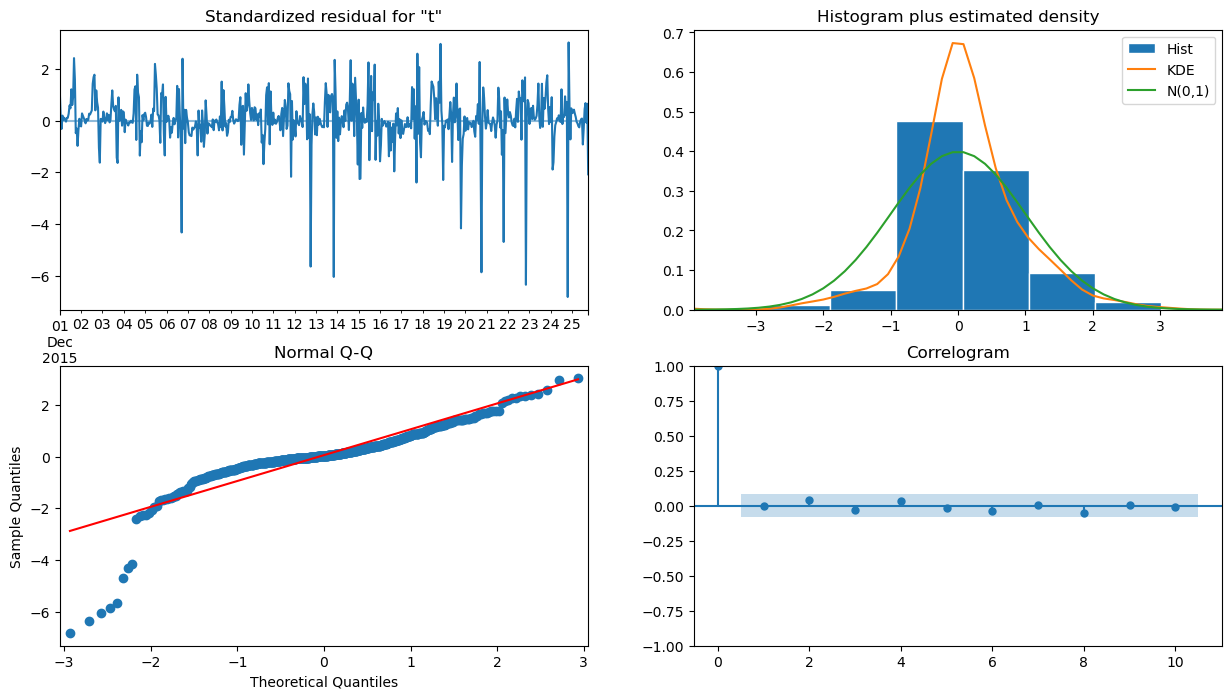

In [14]:
SARIMA_model_fit.plot_diagnostics(figsize=(15,8));

In [15]:
residuals = SARIMA_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)).iloc[:, 1]

if (pvalue > 0.05).all():
    print('Residuals are independent and uncorrelated, model can be used for forecasting.')
else:
    print('Residuals are correlated, model cannot be used for forecasting.')

Residuals are independent and uncorrelated, model can be used for forecasting.


In [157]:
SARIMA_pred = SARIMA_model_fit.forecast(len(test))
sarima_mape = mean_absolute_percentage_error(test['temp'], SARIMA_pred)

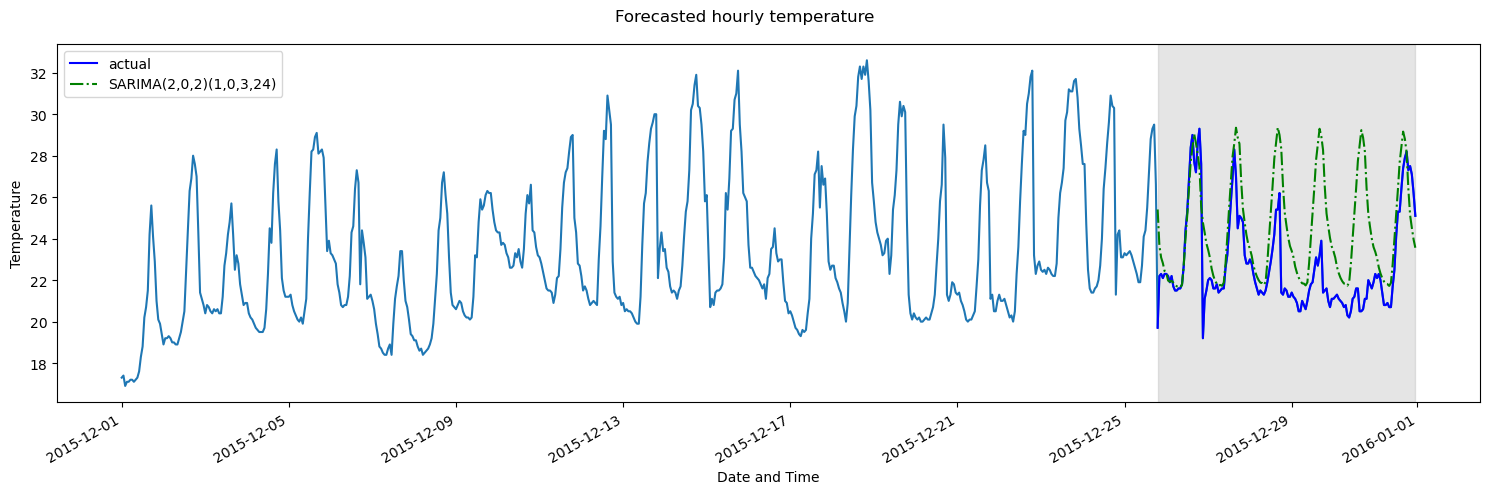

In [167]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sao_paulo_dec_2015_df['temp'])
ax.plot(test['temp'], 'b-', label='actual')
ax.plot(SARIMA_pred, 'g-.', label='SARIMA(2,0,2)(1,0,3,24)')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Temperature')
fig.suptitle('Forecasted hourly temperature')
ax.axvspan(test.index[0], test.index[-1], color='#808080', alpha=0.2)


ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

<h1>LSTM</h1>

In [146]:
multi_window = WindowGenerator(input_width=24, label_width=24, shift=24, train_df=train_scaled[['temp']], val_df=val_scaled[['temp']], test_df=test_scaled[['temp']], label_columns=['temp'])

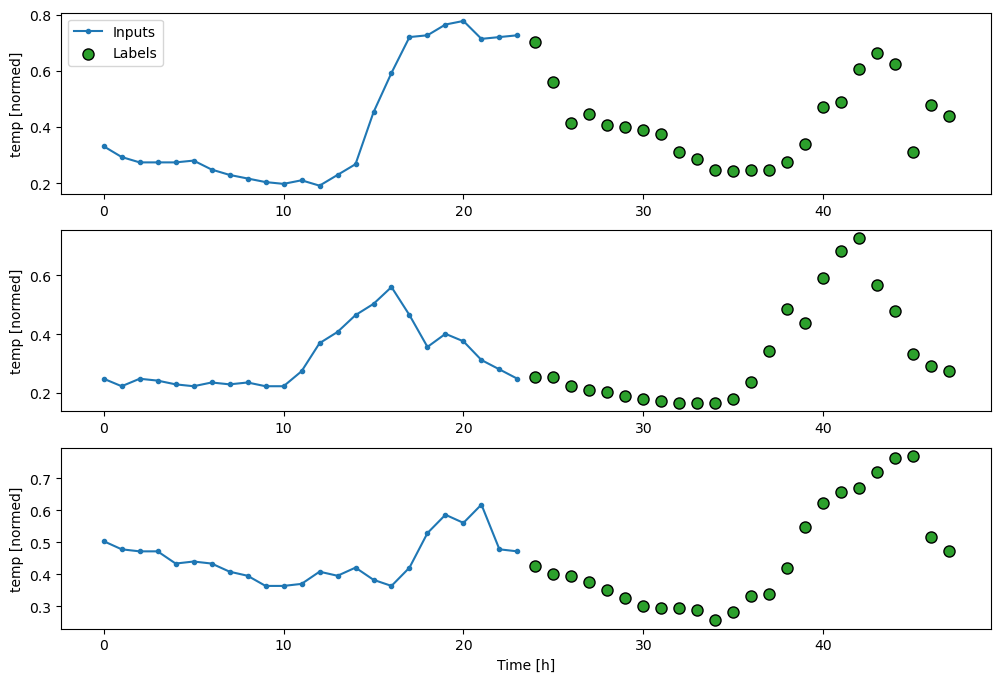

In [147]:
multi_window.plot()

In [149]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(24,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([24, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1968 - mean_absolute_percentage_error: 97.3892 - val_loss: 0.2412 - val_mean_absolute_percentage_error: 86.6754
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1471 - mean_absolute_percentage_error: 74.3561 - val_loss: 0.0722 - val_mean_absolute_percentage_error: 32.6256
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0478 - mean_absolute_percentage_error: 60.6209 - val_loss: 0.0546 - val_mean_absolute_percentage_error: 45.7467
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0431 - mean_absolute_percentage_error: 56.2192 - val_loss: 0.0661 - val_mean_absolute_percentage_error: 35.3758
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0415 - mean_absolute_percentage_error: 49.8728 - val_loss: 0.0572 - val_mean_absolute_percentage_error: 41.4197


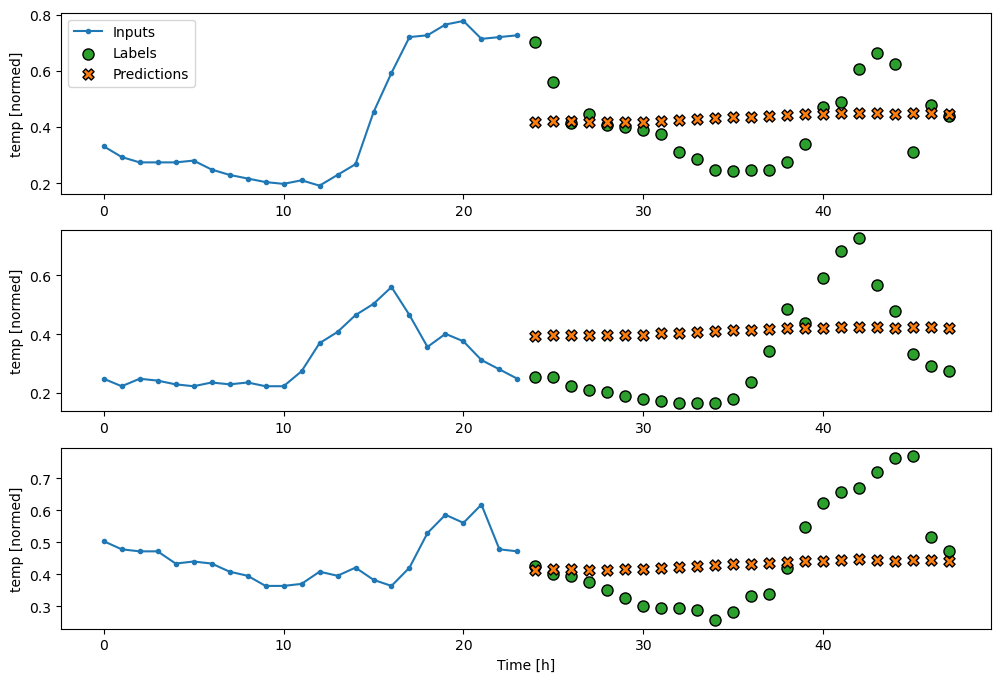

In [150]:
multi_window.plot(multi_lstm_model)

In [154]:
lstm_mape = multi_lstm_model.evaluate(multi_window.test)[1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mean_absolute_percentage_error: 41.6365 


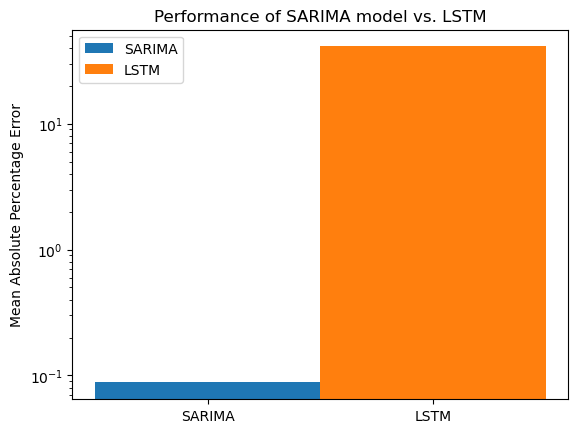

In [166]:
bar_width = 0.3
plt.bar(0, sarima_mape, bar_width, label='SARIMA')
plt.bar(bar_width, lstm_mape, bar_width, label='LSTM')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.title('Performance of SARIMA model vs. LSTM')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks([0, 0.3], ['SARIMA', 'LSTM'])
plt.yscale('log')
plt.legend()

plt.show()